<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Скользящее-среднее" data-toc-modified-id="Скользящее-среднее-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Скользящее среднее</a></span></li><li><span><a href="#Тренды-и-сезонность" data-toc-modified-id="Тренды-и-сезонность-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Тренды и сезонность</a></span></li><li><span><a href="#Стационарные-ряды" data-toc-modified-id="Стационарные-ряды-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Стационарные ряды</a></span></li><li><span><a href="#Разности-временного-ряда" data-toc-modified-id="Разности-временного-ряда-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Разности временного ряда</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
# <импорт библиотеки os>
import os 

# <импорт библиотеки pandas>
import pandas as pd

# <импорт библиотеки sklearn>
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

# <импорт библиотеки lightgbm>
import lightgbm as lgb

# <Отключение библиотеки warnings>
import warnings
warnings.filterwarnings('ignore', category=UserWarning, message='.*[LightGBM].*')

# <импорт библиотеки numpy>
import numpy as np

# <импорт библиотеки matplotlib>
import matplotlib.pyplot as plt

# <импорт библиотеки statsmodels>
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

RANDOM_STATE = 42

In [2]:
pth1 = '/datasets/taxi.csv'
pth2 = '/Users/aleksandrfilippov/Downloads/taxi.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1,index_col=[0], parse_dates=[0])
elif os.path.exists(pth2):
    df = pd.read_csv(pth2,index_col=[0], parse_dates=[0])
else:
    print('Something is wrong')

In [3]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
print(df.info())
df.index.is_monotonic

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


True

In [5]:
df = df.resample('1H').sum()
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB
None


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


### Вывод

Данные выгружены, в обработке не нуждаются. Значения были ресэмплированы по одному часу

## Анализ

In [6]:
print(df['num_orders'].min(), df['num_orders'].max())

0 462


Получается по задаче нужно достичь значения RMSE около 10% от максимально возможного.

Рассмотрим следующие параметры:

- Скользящее среднее
- Тренды и сезонность
- Стационарные ряды
- Разности временного ряда

### Скользящее среднее

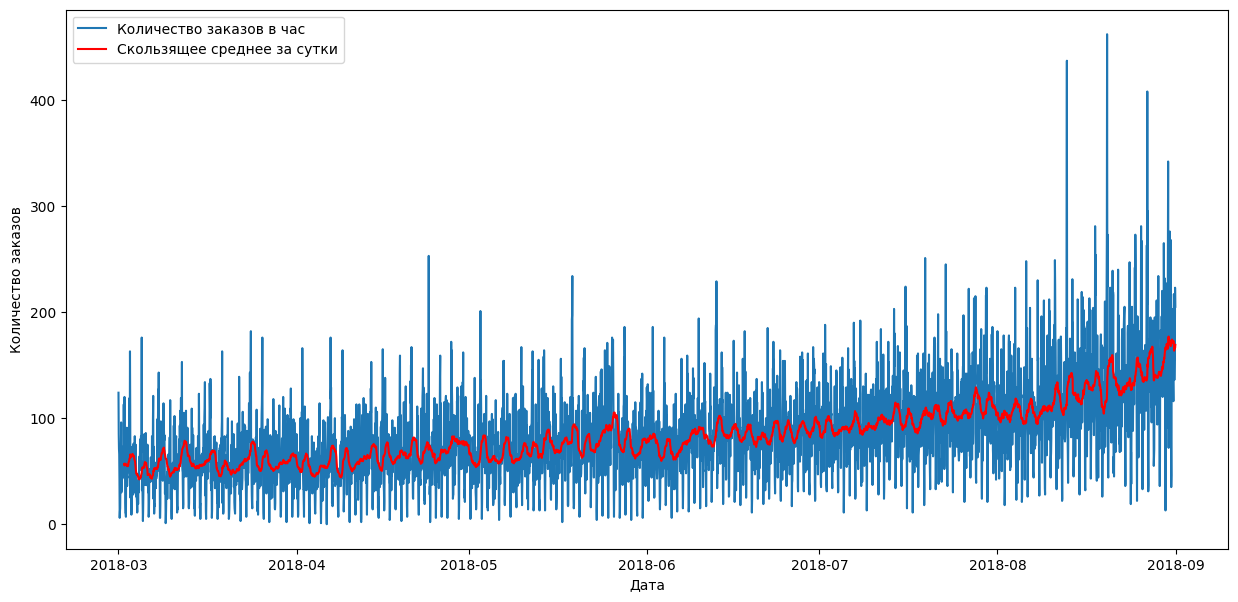

In [7]:
#Для всего датафрейма
plt.figure(figsize=(15, 7))
plt.plot(df)
plt.plot(df.rolling(24, closed = 'left').mean(), color='red')
plt.legend(['Количество заказов в час', 'Скользящее среднее за сутки'])
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

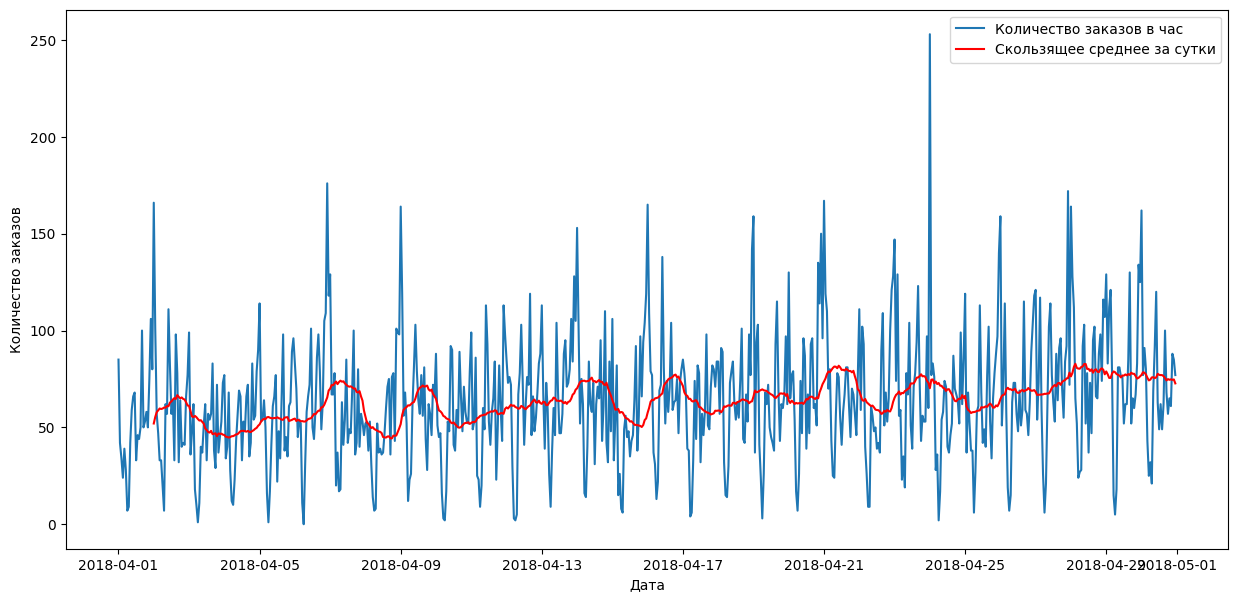

In [8]:
#Для произвольного месяца
plt.figure(figsize=(15, 7))
plt.plot(df['2018-04-01':'2018-04-30'])
plt.plot(df['2018-04-01':'2018-04-30'].rolling(24, closed='left').mean(), color='red')
plt.legend(['Количество заказов в час', 'Скользящее среднее за сутки'])
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

### Тренды и сезонность

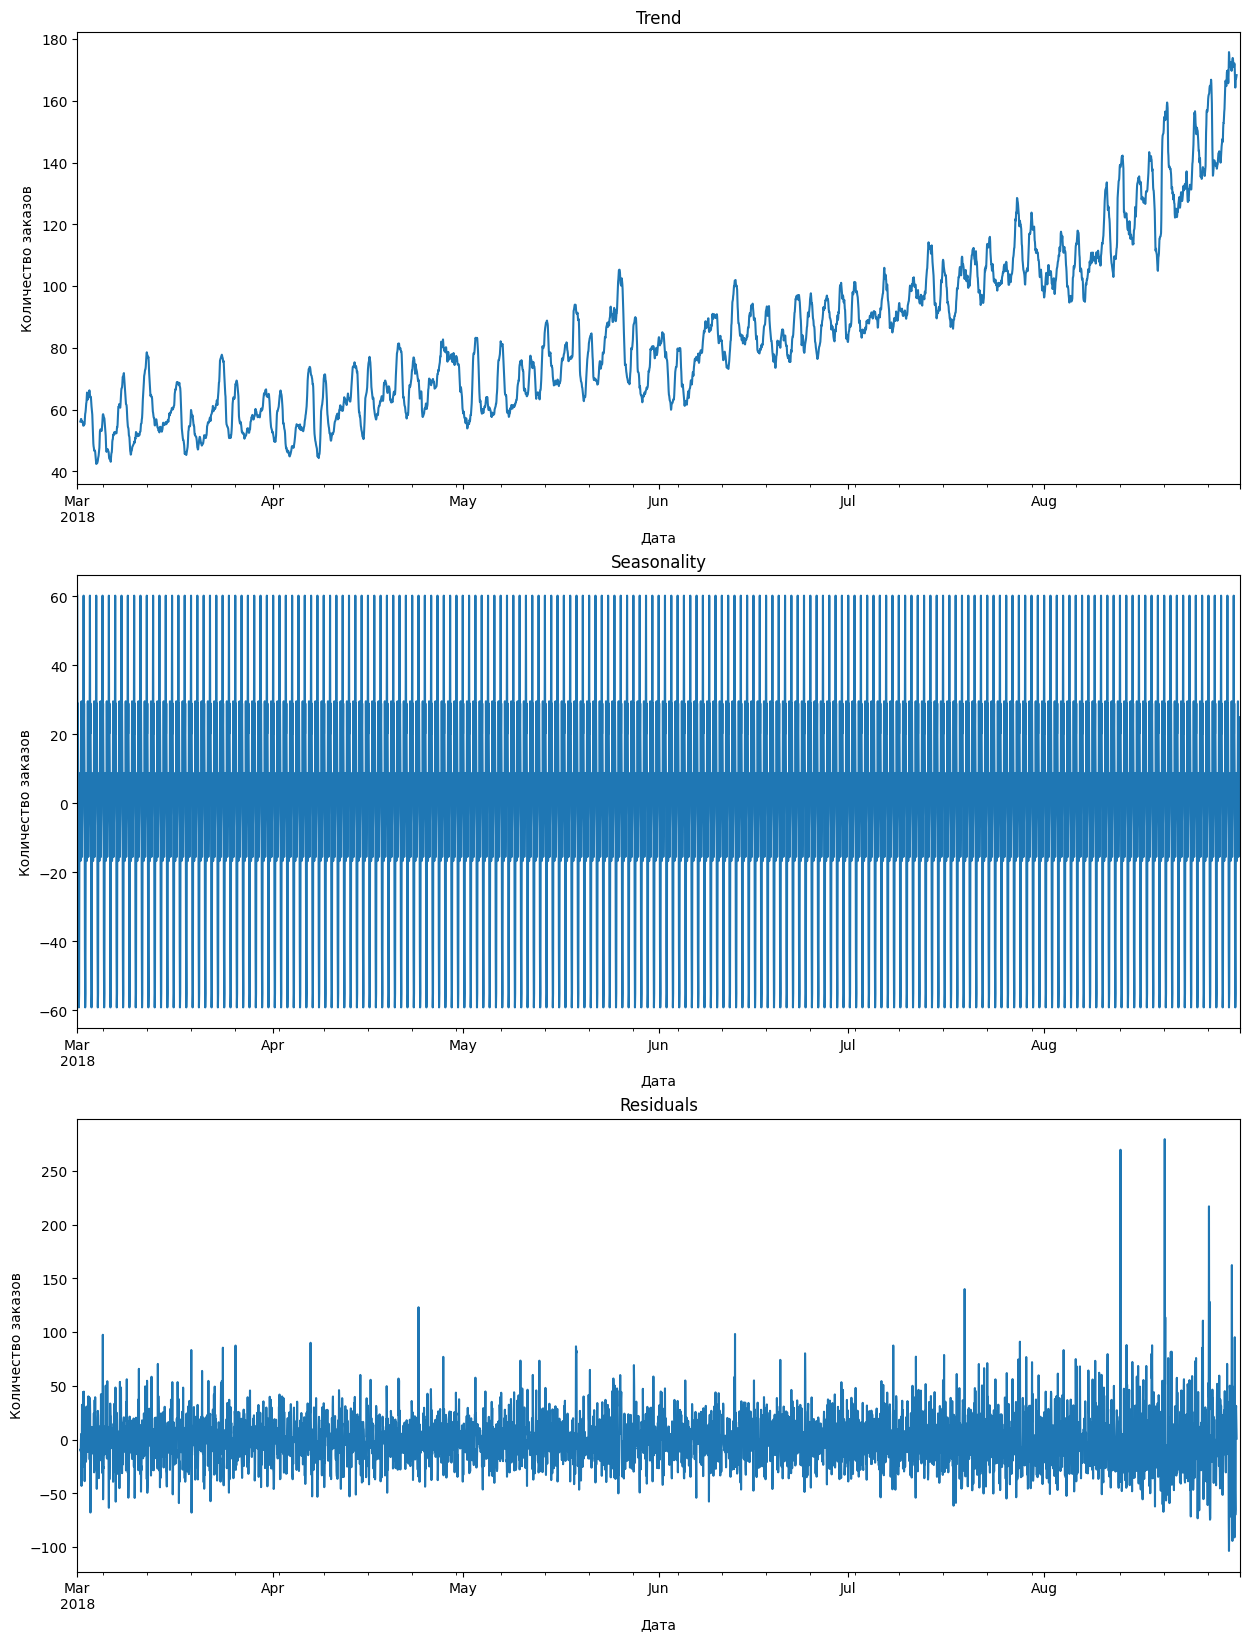

In [9]:
#Декомпозируем данные и выведем график
decomposed = seasonal_decompose(df)

plt.figure(figsize=(15, 20))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')

plt.show()

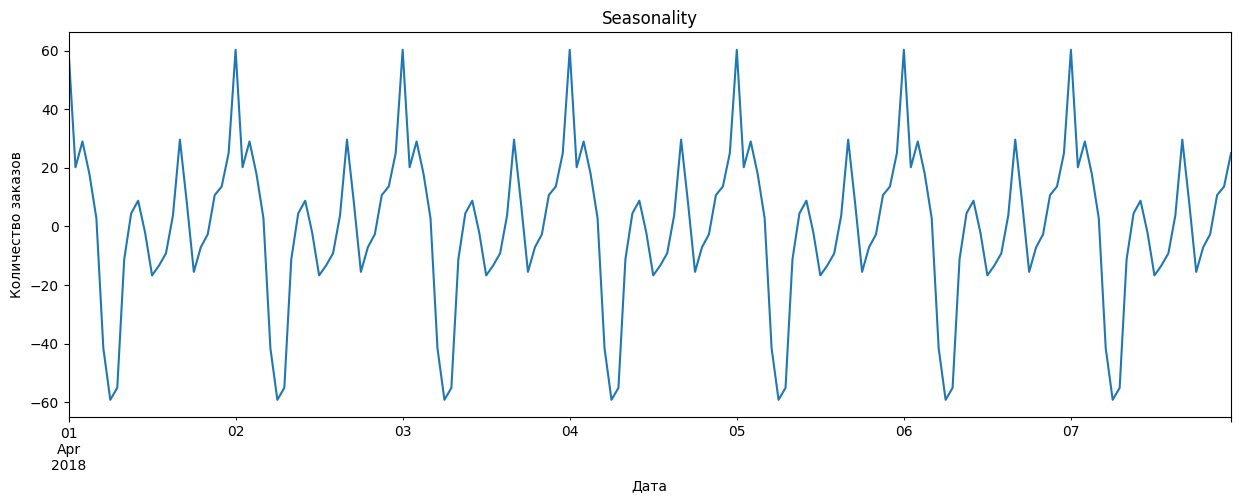

In [10]:
#Отдельно выведем график сезонности на произвольную неделю

plt.figure(figsize=(15, 5))
decomposed.seasonal['2018-04-01':'2018-04-07'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

Из графиков можно сделать следующий вывод:

- Тренд - виден восходящий тренд на количество заказов. Без дополнительных сведений заявлять причину не имеется возможным, однако возможны следующие варианты:
    - Ежеквартальная сезонность, летом спрос выше, однако датафрейм всего лишь на полгода
    - Бренд стал более популярным и с течением времени количество заказов растет
    - Любые другие внешние факторы, влияющие на рост заказов (рекламные кампании, акции, уход конкурентов с рынка и прочее)
- Сезонность - прослеживаются следующие признаки:
    - Резкий спад с 2 до 5 утра
    - Рост заказов с 6 утра до 15 с шагом в 2-3 часа и небольшим спадом каждые 1-2 часа
    - Пиковые значения в полночь
        - **Природа сезонности суточная, предположительно обусловлена графиком вылета/прилета. Ночью общественный транспорт перестает работать, поэтому прослеживается пиковые значения около 00 часов, однако к 02 часам начинается резкий спад, что обусловленно низким количеством прилетающих рейсов**
- Шум - видно растущее количество выбросов и их сила ближе к лету

### Стационарные ряды

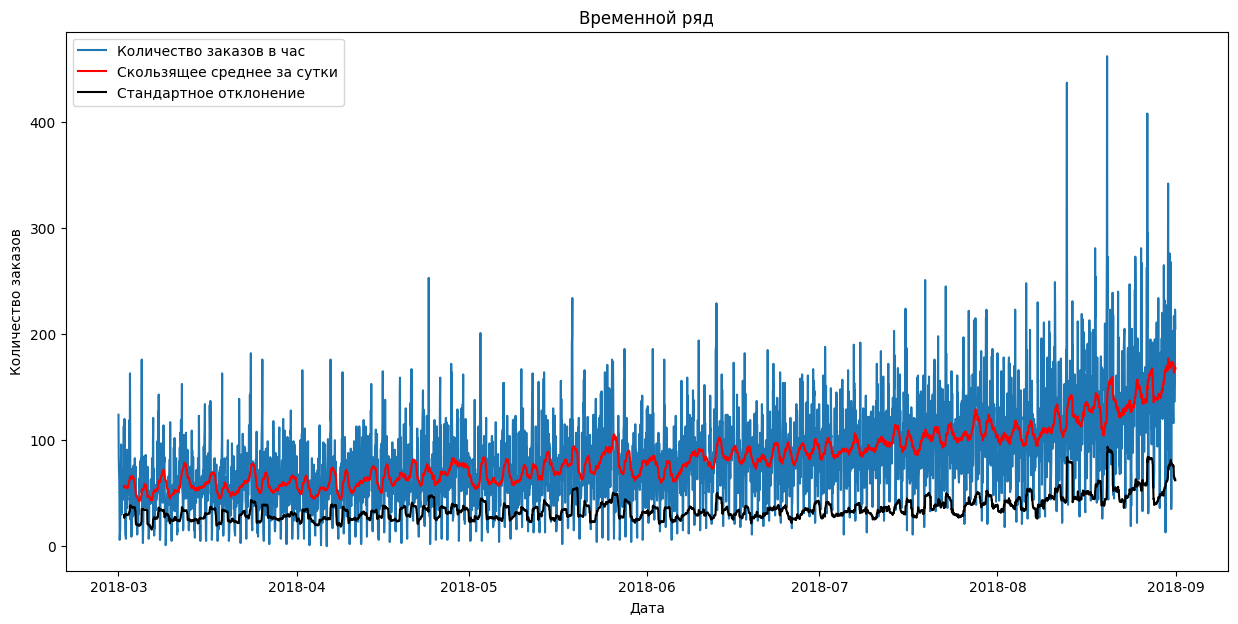

In [11]:
# Добавим стандартное отклонение
plt.figure(figsize=(15, 7))
plt.plot(df)
plt.plot(df.rolling(24).mean(), color='red')
plt.plot(df.rolling(24).std(), color='k')
plt.title('Временной ряд')
plt.legend(['Количество заказов в час', 'Скользящее среднее за сутки', 'Стандартное отклонение'])
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

По восходящему тренду стандартного отклонения можно сделать вывод, что ряд в данном случае нестационарный, предсказательная сила может снизиться

In [12]:
alpha_95 = 0.05
alpha_99 = 0.01

result = adfuller(df, autolag='AIC')

if result[1] < alpha_95:
    print('Нулевая гипотеза для 5% отвергнута – Временной ряд стационарен')
else:
    print('Нулевая гипотеза для 5% не отвергнута – Временной ряд не стационарен')

if result[1] < alpha_99:
    print('Нулевая гипотеза для 1% отвергнута – Временной ряд стационарен')
else:
    print('Нулевая гипотеза для 1% не отвергнута – Временной ряд не стационарен')

result[1]

Нулевая гипотеза для 5% отвергнута – Временной ряд стационарен
Нулевая гипотеза для 1% не отвергнута – Временной ряд не стационарен


0.02894005140261345

## Обучение

Алгоритм обучения и тестирования следующий:

- Добавим признаки (месяц, день, день недели, час, отстающие значения, скользящее среднее)
- Разобьем выборку на обучающую и тестовую (в соотношении 90:10)
- Обучим следующие модели (Линейная регрессия, Случайный лес, lgbRegressor)
- Выберем лучшую модель для теста по метрике RMSE на трейне и протестируем

In [14]:
def make_features(data, max_lag, rolling_mean):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean).mean()
    return data

In [15]:
df_preprocessed = make_features(df, 24, 24)

In [16]:
train, test = train_test_split(df_preprocessed, shuffle=False, test_size=0.1)
train = train.dropna()

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

x_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
x_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

2018-03-02 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [17]:
def best_params(model, params):
    time_series_cv = TimeSeriesSplit()
    model_name = GridSearchCV(estimator = model,
                              param_grid = params,
                              cv = time_series_cv,
                              scoring='neg_root_mean_squared_error'
                             ) 
    model_name.fit(x_train, y_train)
    
    rmse = model_name.best_score_ * -1 
    
    best_model = model_name.best_params_
    
    print('Лучшие параметры:', best_model)
    print('RMSE:', rmse)
    
    return model_name

In [18]:
def show_predict(model_name, x, y):
    predict_values = pd.DataFrame(model_name.predict(x), index=x.index)
    plt.figure(figsize=(15,10))
    plt.plot(y, color='black')
    plt.plot(predict_values, color='red')
    plt.title('Сравнение предсказанных значений с реальными')
    plt.ylabel('Количество заказов')
    plt.xlabel('Дата')
    plt.legend(['Реальные', 'Предсказанные'])
    plt.show()

In [19]:
hyper_params_rf = {'max_depth': list(range(3, 10)),
                   'n_estimators': [50, 100, 200, 300],  
                  }

model_rf = RandomForestRegressor(random_state=RANDOM_STATE)

model_rf_best = best_params(model_rf, hyper_params_rf)

Лучшие параметры: {'max_depth': 9, 'n_estimators': 300}
RMSE: 25.58237816791864


In [20]:
hyper_params_lgb = {
                    'learning_rate': [0.01, 0.05, 0.1, 0.2],
                    'num_iterations': [100, 250, 500, 750, 1000],
                    'boosting_type': ['gbdt', 'dart']
}

model_lgb = lgb.LGBMRegressor(random_state = RANDOM_STATE, 
                             task = 'train', 
                             objective = 'regression',
                             verbosity=-1)

model_lgb_best = best_params(model_lgb, hyper_params_lgb)

Лучшие параметры: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'num_iterations': 750}
RMSE: 24.831683812456895


## Вывод

Были подготовлены данные к обучению и обучены три модели(случайный лес, градиентный бустинг, дарт)

По RMSE на трейн выборке лучше всего показала себя модель дарт со значением 14.6, ее и будем тестировать

## Тестирование

RMSE на тестовой выборке: 41.89310372786935


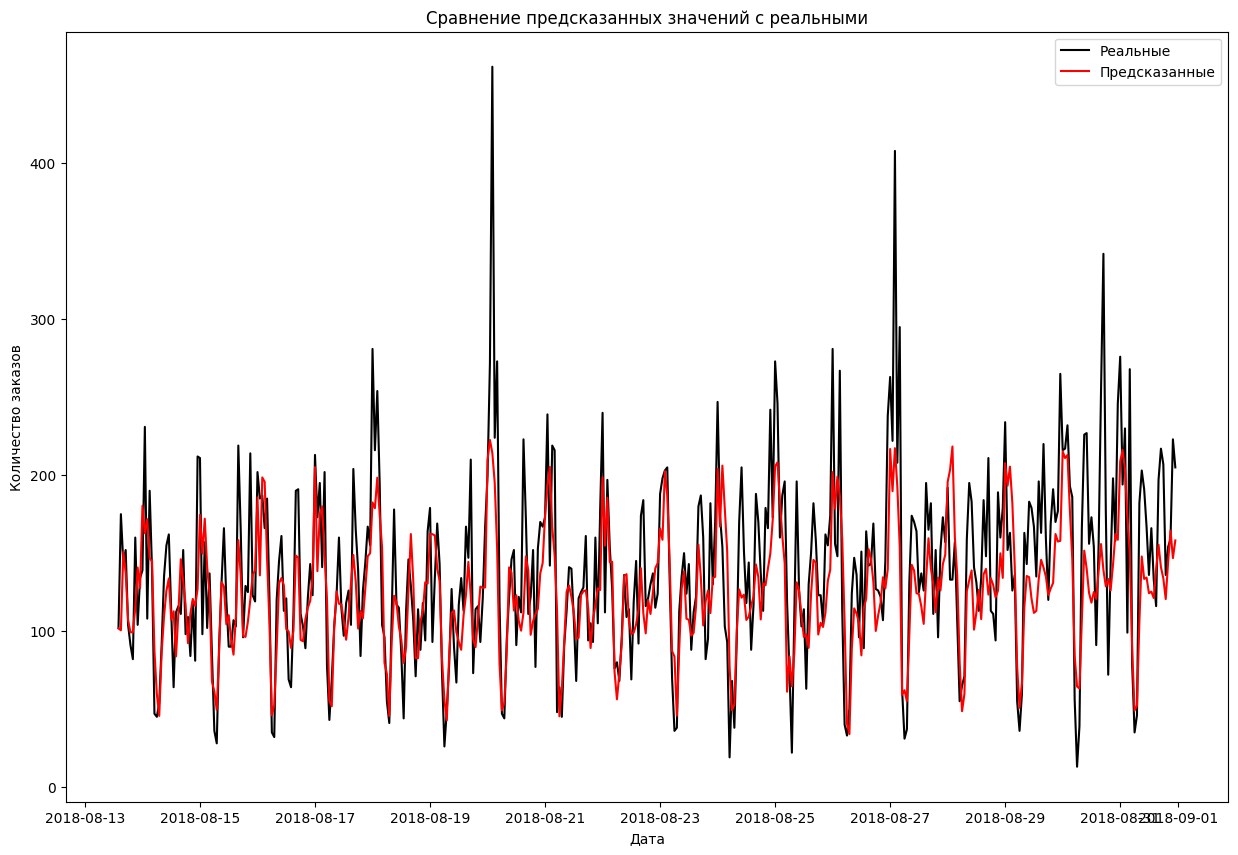

In [21]:
test_pred = model_lgb_best.predict(x_test)

print('RMSE на тестовой выборке:', mean_squared_error(test_pred,y_test)**0.5)

show_predict(model_lgb_best,x_test,y_test)

In [22]:
dummy = DummyRegressor(strategy='mean').fit(x_train, y_train)
predictions = dummy.predict(x_test)
print('RMSE на тестовой выборке:', mean_squared_error(y_test,predictions)**0.5)

RMSE на тестовой выборке: 84.6499381993622


## Вывод

Требования задачи выполнены, RMSE модели DART показала 41.9, что меньше 48.